<a href="https://colab.research.google.com/github/VerbalAid/Analysing-Mcdonalds-Menu-Nutritional-facts/blob/main/Lab4_RAG_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a RAG-based assistant

This notebook demonstrates how you can build a RAG (Retrieval Augmented Generation) model for answering a user's question about a specific knowledge base. We will use the HuggingFace documentation as an example knowledge base, and then propose a selection of datasets so that you can try to build your own RAG system. This way, we can create a valuable assistant that can answer your questions by retrieving relevant information from a given knowledge base.

In short, the notebook consists of five different sections:

1.   A short summary of what **RAG models** are.
2.   **The retriever module** and the integration of the knowledge base in it.
3.   **The reader module** and improving the retrieval process with reranking.
4.   Building a **RAG-based assistant** with the previous two modules.
5.   Play time! **Build your own assistant** choosing one of the proposed knowledge bases and following this notebook's implementation as an example.

> 💡 The entire notebook is runnable in the free version of Colab. The models we use are either small or quantized, and all of them can be loaded at the same time for inference with less than 7GBs of VRAM required. We will not fine-tune any model.

The notebook you are reading is an adapted version of [this notebook](https://huggingface.co/learn/cookbook/advanced_rag).

Before starting to read the theory about RAG, let's install the dependencies needed for this lab. We recommend to start reading the theory during this installation, as it will take a while to install them all.

In [ ]:
!pip install torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu-cu11 openpyxl pacmap datasets langchain-community ragatouille tqdm

In [ ]:
import os
from google.colab import userdata
hf_token = userdata.get("HF_TOKEN")
os.environ['HF_TOKEN'] = hf_token

In [ ]:
!hf auth login --token $HF_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: write).
The token `llms_course` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## 1. What Are Retrieval Augmented Generation Models?

RAG is a popular approach to address the issue of a powerful LLM not being aware of specific content due to said content not being in its training data, or hallucinating even when it has seen it before. Such specific content may be proprietary, sensitive, or, as in this example, recent and updated often.

If your data is static and doesn't change regularly, you may consider fine-tuning a large model. In many cases, however, fine-tuning can be costly, and, when done repeatedly (e.g. to address data drift), leads to "model shift". This is when the model's behavior changes in ways that are not desirable.

RAG does not require model fine-tuning. Instead, RAG works by providing an LLM with additional context that is retrieved from relevant data so that it can generate a better-informed response.

Here's the schema of a typical RAG model:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

We recommend to come back to this image as many times as you need, as it will help you to recognize when each model is needed and how data flows through the entire RAG model.

RAG consists of two main modules:

1. Retriever module: Given a user query, it return the top-k relevant documents that will be used as the context to answer the question specified in the query. By preprocessing and chunking into documents the text that make up the knowledge base, each document gets an embedding representation. The user query is then embedded into the same space and the documents with the k closest embeddings to the query embedding are retrieved.

2. Reader module: Once we get the top-k relevant documents from the retriever, we combine them with the query to feed it to an LLM that will answer the question contained in the query using the context defined by the retrieved documents.


A couple of final notes about RAG:

* The selected knowledge base is converted into embedding vectors with a separate embeddings model, and the vectors are kept in a vector database. Embeddings models are typically small, so updating the embedding vectors on a regular basis is faster, cheaper, and easier than fine-tuning a model.

* At the same time, the fact that fine-tuning is not required gives you the freedom to swap your LLM for a more powerful one when it becomes available, or switch to a smaller distilled version, should you need faster inference.

* The retriever and reader modules can be farther enhanced with different submodules. In the image above, the blue texts give us an idea of how can we improve RAG's abilities to retrieve and answer the query correctly. In this notebook we will also explore the reranking of retrieved documents by using a more complex retriever on the initial retrieved documents.

* When the embedding model has issues to embed documents or queries into a meaningful space, it might be desirable for the retriever module to be fine-tuned in order to adapt to that specific domain. However, in this notebook we will not explore this idea.

> 💡 As you can see, there are many steps to tune in this architecture: tuning the system properly will yield significant performance gains.

## 2. Retriever Module 🗂️

As said before, the __retriever acts like an internal search engine__: given the user query, it returns a few relevant snippets from your knowledge base. These snippets will then be fed to the Reader Model to help it generate its answer.

So __our objective here is, given a user question, to find the most relevant snippets from our knowledge base to answer that question.__

This is a wide objective, it leaves open some questions. How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`. There's no one-size-fits-all answers, but here are a few elements:
- 🔀 Your `chunk size` is allowed to vary from one snippet to the other.
- Since there will always be some noise in your retrieval, increasing the `top_k` increases the chance to get relevant elements in your retrieved snippets. 🎯 Shooting more arrows increases your probability of hitting your target.
- Meanwhile, the summed length of your retrieved documents should not be too high: for instance, for most current models 16k tokens will probably drown your Reader model in information due to [Lost-in-the-middle phenomenon](https://huggingface.co/papers/2307.03172). 🎯 Give your reader model only the most relevant insights, not a huge pile of books!


> 💡 In this notebook, we use Langchain library since __it offers a huge variety of options for vector databases and allows us to keep document metadata throughout the processing__.

### 2.1. Building the document store

The snippets of text that form the knowledge base will be stored in a document store, so that indexing and generating their embeddings becomes an easier task for us.



We will start by importing the modules necessary to load the knowledge base and visualize it.

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

With the following cell, we load the HuggingFace documention that we will use as our knowledge base...

In [ ]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

...and build the document store using LangChain.

In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

### 2.2. Splitting the documents into chunks

In this part, __we split the documents from our knowledge base into smaller chunks__ which will be the snippets on which the reader LLM will base its answer.

The goal is to prepare a collection of **semantically relevant snippets**. So their size should be adapted to precise ideas: too small will truncate ideas, and too large will dilute them.

> 💡 _Many options exist for text splitting: splitting on words, on sentence boundaries, recursive chunking that processes documents in a tree-like way to preserve structure information... To learn more about chunking, [this notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) by Greg Kamradt will be of great help._

**Recursive chunking** breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn't give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators `["\n\n", "\n", ".", ""]`:
    - The method will first break down the document wherever there is a double line break `"\n\n"`.
    - Resulting documents will be split again on simple line breaks `"\n"`, then on sentence ends `"."`.
    - Finally, if some chunks are still too big, they will be split whenever they overflow the maximum size.

With this method, the global structure is well preserved, at the expense of getting slight variations in chunk size.

> 💡 [This space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different splitting options affect the chunks you get.

We use Langchain's implementation of recursive chunking with `RecursiveCharacterTextSplitter`.
- Parameter `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters (or tokens if we use a tokenizer) in the chunk.
- Parameter `chunk_overlap` lets adjacent chunks get a bit of overlap on each other. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks. We ~arbitrarily set this to 1/10th of the chunk size, you could try different values!

First, we define the markdown separators that will be used during the recursive chunking of documents to separate docs as best as possible, as well as the name of the embedding model that we will use for this example.

In [ ]:
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

Now, we define `split_documents()` that will split all documents of the knowledge base into the desired chunk size. This chunk size corresponds to the number of tokens of the document after tokenizing it with the given tokenizer.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

By choosing an appropiate chunk size, we split the documents with the function defined above.

In [ ]:
from sentence_transformers import SentenceTransformer

# We choose a chunk size adapted to our model
max_seq_length = SentenceTransformer('thenlper/gte-small').max_seq_length
print(f"Model's maximum sequence length: {max_seq_length}")

docs_processed = split_documents(
    max_seq_length,
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


By running the following cell, we will visualize the histogram of chunk sizes of our final document list, ensuring that all documents have a length smaller than `max_seq_length == 512`

  0%|          | 0/16776 [00:00<?, ?it/s]

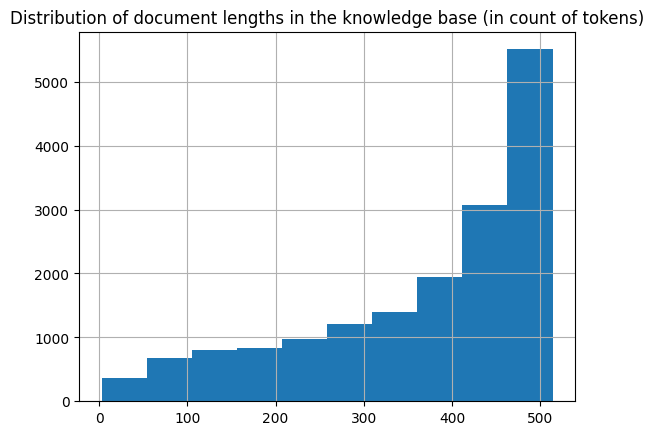

In [ ]:
# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### 2.3. Building the vector database



We want to compute the embeddings for all the chunks of our knowledge base: to learn more about sentence embeddings, we recommend reading [this guide](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/).

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

Regarding distances, you can find a good guide [here](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings). In short:

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

You can try [this small exercise](https://developers.google.com/machine-learning/clustering/similarity/check-your-understanding) to check your understanding of these concepts. But once vectors are normalized, [the choice of a specific distance does not matter much](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use).

Our particular model works well with cosine similarity, so choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

🚨👇 The cell below will do everything, but it takes a few minutes to run!

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from tqdm import tqdm

# Load embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

# Compute our vector database using the embedding model
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

# If GPUs are not available use this... but it lasts 2 DAYS!!
# KNOWLEDGE_VECTOR_DATABASE = None
# with tqdm(total=len(docs_processed), desc="Ingesting documents") as pbar:
#     for d in docs_processed:
#         if KNOWLEDGE_VECTOR_DATABASE:
#             KNOWLEDGE_VECTOR_DATABASE.add_documents([d])
#         else:
#             KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents([d], embedding_model, distance_strategy=DistanceStrategy.COSINE)
#         pbar.update(1)

/tmp/ipython-input-622355465.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


### 2.4. Trying the retriever module

Having our vector database ready, let's try to retrieve top-5 most relevant documents for the given `user_query`!

In [ ]:
user_query = "How to create a pipeline object?"
k = 5

In the LangChain vector database implementation, this search operation is performed by the method `vector_database.similarity_search(query)`.

In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=k)

print(
    f"\n===============================Top {k} documents==============================="
)
for i in range(k):
    print(retrieved_docs[i].page_content)

print("==================================Metadata==================================")
for i in range(k):
    print(retrieved_docs[i].metadata)



Starting retrieval for user_query='How to create a pipeline object?'...

===============================Top 5 documents===============================
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
```

2. Pass a prompt to the pipeline to generate an image:

```py
image = pipeline(
	"stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k"
).images[0]
image
- Pipelines should be very readable, self-explanatory, and easy to tweak.
- Pipelines should be designed to build on top of each other and be easy to integrate into higher-level APIs.
- Pipelines are **not** intended to be feature-

💡 Note that we are using the same model encode the query and all the documents. In some other cases, two different models are trained to encode queries and documents to the same space, one for each.

We can visualize the search for the closest documents. To do so, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP. We chose PaCMAP rather than other techniques such as t-SNE or UMAP, since [it is efficient (preserves local and global structure), robust to initialization parameters and fast](https://www.nature.com/articles/s42003-022-03628-x#Abs1).

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

# Embed a user query in the same space as the docs
query_vector = embedding_model.embed_query(user_query)

# Define the PaCMAP projector instance
embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

# Define all embeddings to be plotted
embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

With the projected documents into a 2D space, let's visualize these embeddings with matplotlib.

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show(interactive=True)

➡️ On the graph above, you can see a spatial representation of the knowledge base documents. As the vector embeddings represent the document's meaning, their closeness in meaning should be reflected in their embedding's closeness.

The user query's embedding is also shown: we want to find the `k` documents that have the closest meaning, thus we pick the `k` closest vectors shown at the start of this subsection.


## 3. Reader Module 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 3.1. The LLM-based Reader

The reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.

For this example, we chose [`Qwen/Qwen2.5-7B-Instruct`](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct), a "small" but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).



To make inference faster and lighter, we will load the quantized version of the model:

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

#READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"
#READER_MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
READER_MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=512,
)

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Let's try this reader LLM!

In [ ]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8. The process of adding two numbers together involves combining their values to find the total sum. In this case, we are adding four and four. Four plus four equals eight. This can be visualized as having four objects in one group and four objects in another group, then counting all the objects together to get a total of eight. Another way to think about it is that when you add the same number twice, you double its value. So, doubling four results in eight. Therefore, 4 + 4 = 8.'}]

### 3.2. Prompt for an Assistant

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|im_start|>system
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.<|im_end|>
<|im_start|>user
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}<|im_end|>
<|im_start|>assistant



Let's test our Reader on our previously retrieved documents!

In [ ]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object, you typically follow these steps:

1. Decide on the inputs and outputs for the pipeline.
2. Inherit from the appropriate base class (e.g., `Pipeline`).
3. Implement the necessary methods such as `preprocess`, `_forward`, `postprocess`, and `_sanitize_parameters`.
4. Define the `__call__` method to handle the main logic including preprocessing, diffusion, and postprocessing.

Here's a simplified example based on the provided documentation:

```python
from transformers import Pipeline

class CustomPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        # Sanitize parameters if needed
        preprocess_kwargs = {}
        if "maybe_arg" in kwargs:
            preprocess_kwargs["maybe_arg"] = kwargs["maybe_arg"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, inputs, maybe_arg=2):
        # Preprocess the inputs
        model_input = Tensor(inputs["input_ids"])
        return {"model_input": model_input}

    def _forward(s

### 3.3. Reranking Retrieved Documents

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, [Colbertv2](https://arxiv.org/abs/2112.01488) is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is easily usable thanks to [the RAGatouille library](https://github.com/bclavie/RAGatouille).

In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

/tmp/ipython-input-284762153.py:1: UserWarning:


********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************



artifact.metadata: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



## 4. Assembling all modules 🛠️

In the following cell, we define the function `answer_with_rag()` that implements the image shown in the beggining of this notebook. Its arguments are:

* `question`: The query given by the user.
* `llm`: The reader LLM that generates the answer of `question` with the retrieved documents.
* `knowledge_index`: The FAISS index that stores all document snippets and their respective embeddings.
* `reranker`: The reranker model can be added as an optional model.
* `num_retrieved_docs`: Number of retrieved docs on the initial retriever process.
* `num_docs_final`: Number of final documents retrieved after applying the reranker.

In [ ]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

With the function above, let's try and run our RAG assistant!

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

The results will be shown in the cell below.

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

✅ We now have a fully functional, performant RAG system. That's it for today! Congratulations for making it to the end... HA! This is just where you start tweaking the code ;)

# 5. To go further 🗺️

How about adapting the code to change this HuggingFace Docs assistant into an assistant with access to the trilogy of The Lord of the Rings or, even better, to the PokeDex. Choose one of the following, or any dataset you like to create your personalized assistant:

* [Pokemon Dataset](https://www.kaggle.com/datasets/hanicier/master-pokemon-dataset-with-corpus-version): Check the `pokemon_corpus.csv` to get text snippets of each Pokemon and build a FAISS index with them.
* [The Lord of the Rings](https://www.kaggle.com/datasets/ashishsinhaiitr/lord-of-the-rings-text): Each book of the trilogy is divided in three .txt files. Chunking them correctly will be key for the good performance of the retriever.
* [LangChain Docs](https://huggingface.co/datasets/jamescalam/langchain-docs): The easiest to adapt to. It follows a similar structure as the one in the example, as you can use the `datasets` module to load it.

You might need to define new strategies to split the documents. Good luck with it!


You can also do many things to improve your RAG system, a.k.a. the code of this notebook. We recommend doing so in an iterative way: bring small changes to the system and see what improves performance.

For this lab, we recommend to work on (one of) the following changes:

* Improve the retriever by...
  - Tuning the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
  - Changing the embedding model

* Improve the reader by...
  - Tuning the prompt
  - Switching reranking on/off
  - Choosing a more powerful reader model

For those eager to play around more with the code, you can:

* Improve the retriever by...
  - Trying another chunking method, like semantic chunking
  - Changing the index used (in this notebook we have used FAISS)
  - Reformulating the user query in slightly different ways to retrieve more documents (query expansion)

* Improve the reader by...
  - Compress the retrieved context to keep only the most relevant parts to answer the query.
  - Extend the RAG system to make it more user-friendly:
     - Cite source document when giving an answer
     - Make a chat-bot to enable dialogs with the reader